# Dphi Data Sprint 88 - Abalone Age Prediction
## Predict the age of abalone from physical measurements.
### Link to original challenge: https://dphi.tech/challenges/data-sprint-88-abalone-age-prediction/256/overview/about
### Models in this notebook were trained on Kaggle GPU, link: https://www.kaggle.com/code/sandeepmajumdar/abalone-age-prediction-deep-learning-3
### Part-1 of the notebook where Random Forest was the winning model: https://www.kaggle.com/code/sandeepmajumdar/abalone-age-prediction-random-forest-1
### Link to the dataset used: https://www.kaggle.com/datasets/sandeepmajumdar/abalone-age-prediction

## Methodology:
1. Visualize the data and perform exploratory analysis based on univariate and multivariate analysis
2. Target is integral, so results will be rounded before submission
3. In the first notebook we used ML algorithms, in this we will use Deep Learning
4. First we will use DL on the data after normalizing it
5. Next, we'll create feature interactions and perform DL again

## Model architectures in this notebook consistently achieved best LB scores around 2.05 - 2.08

## Import the libraries

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
from tqdm import tqdm
import time
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import regularizers, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

## Define the filepaths

In [2]:
train_path = '../input/abalone-age-prediction/train_dataset.csv'
test_path = '../input/abalone-age-prediction/test_dataset.csv'

## Read the datasets

In [3]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
display(train_df.head(1))
display(test_df.head(1))

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,rings
0,124,97,41,243.8,77.5,50.1,77.0,0,0,1,14


,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M
0,111,87,29,139.5,52.4,31.5,48.0,0,1,0


## Visualize the target

<AxesSubplot:ylabel='Frequency'>

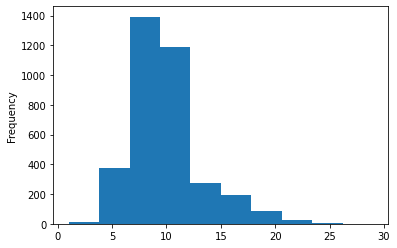

In [4]:
train_df.rings.plot(kind='hist')

### Target feature looks normal

## Univariate analysis

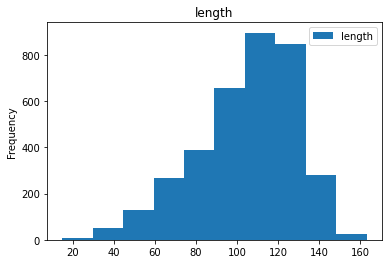

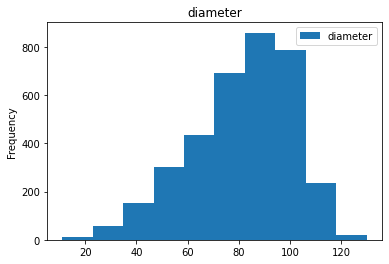

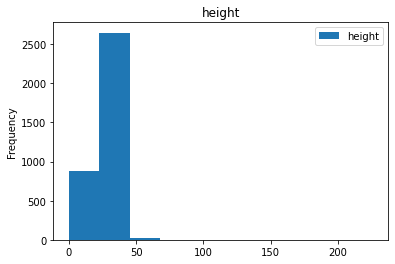

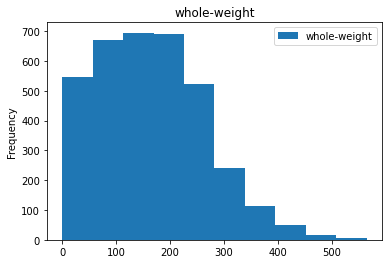

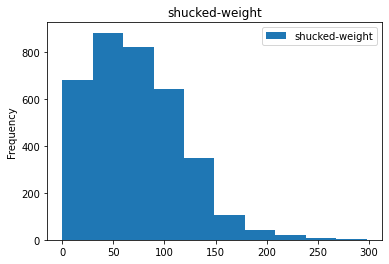

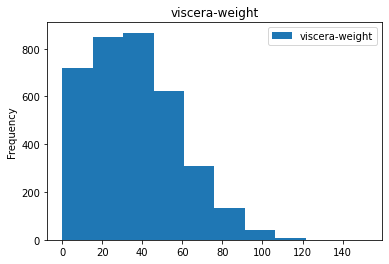

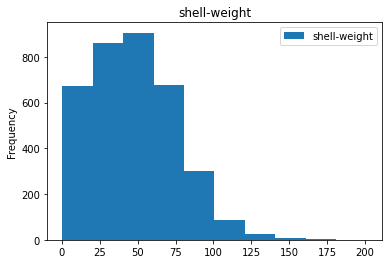

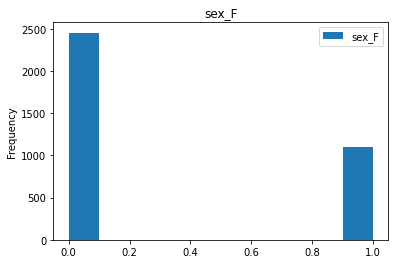

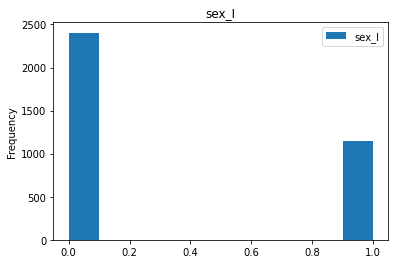

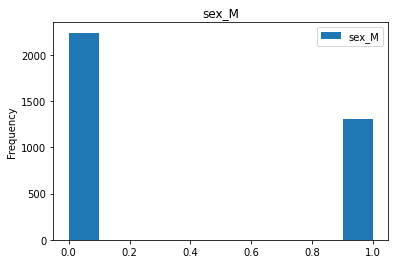

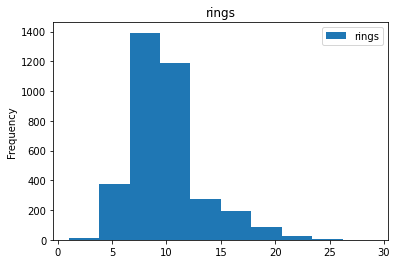

In [5]:
for i in train_df.columns:
    train_df[i].plot(kind='hist', title=i)
    plt.legend()
    plt.show()

### Other than height feature, all others look normal. For height feature, givan more data, we can think of log normalization

## We saw in the ML notebook that the 'sex' feature had redundancies and we dropped one feature. In this notebook since we will prepare feature interactions, we'll not drop the extra featue

## Bivariate analysis

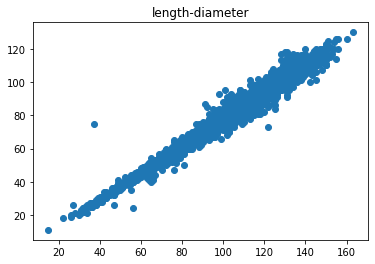

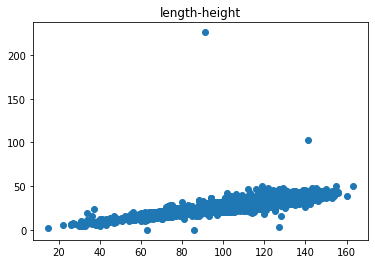

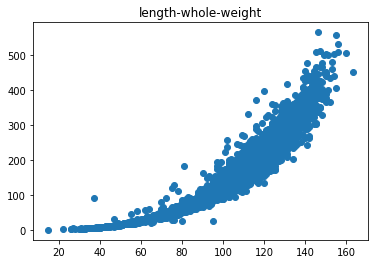

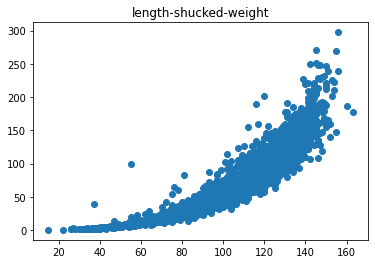

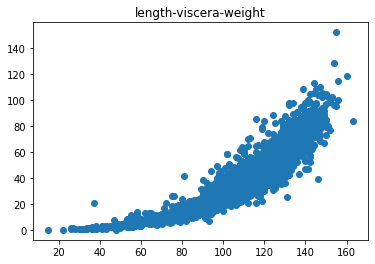

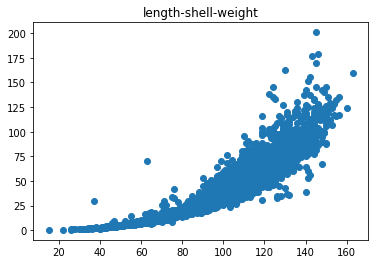

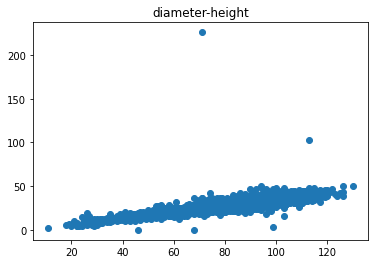

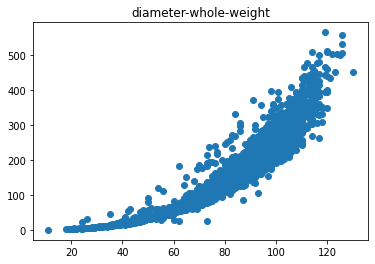

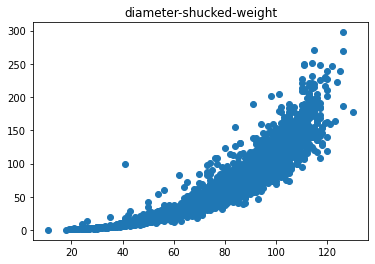

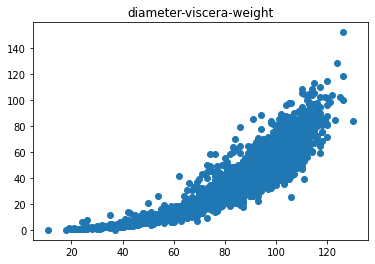

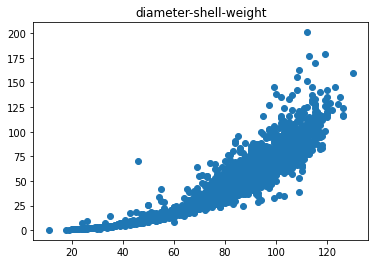

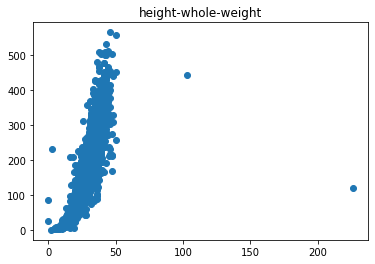

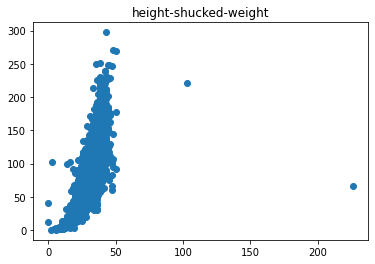

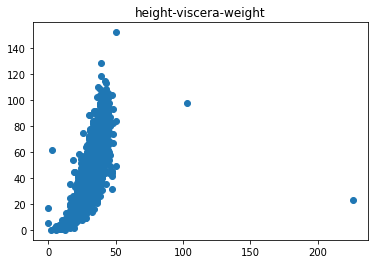

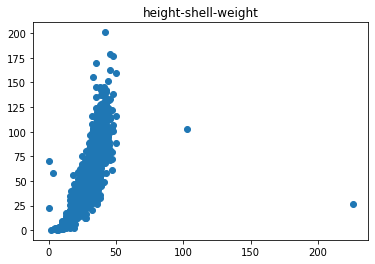

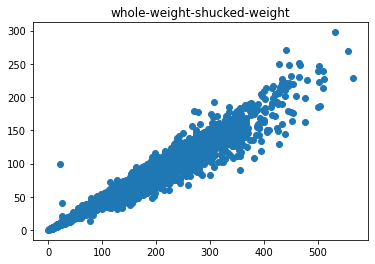

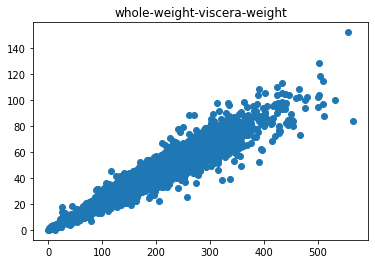

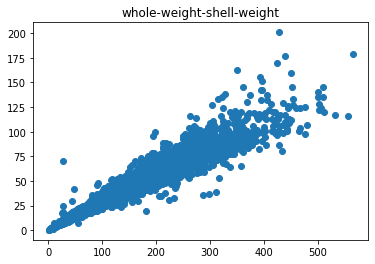

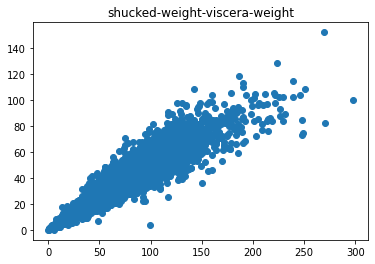

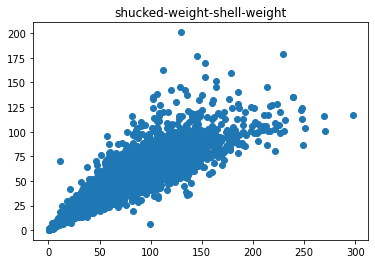

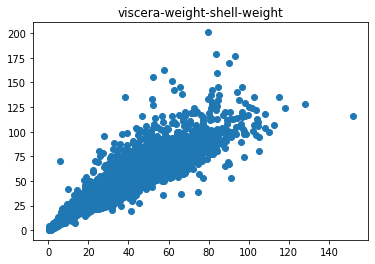

In [6]:
cols = list(train_df.iloc[:,:7].columns)
for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        plt.scatter(train_df[cols[i]], train_df[cols[j]])
        plt.title(cols[i]+'-'+cols[j])
        plt.show()

### Most of the parameters have linear relationships, except for weight. Because of weight, linear algorithms might perform poorly and tree algorithms or deep learning will perform better

### Still, the data is very clean, and can be straightaway used for modeling

## Feature Engineering, Feature Selection

## Separate the dependent and independent features

In [7]:
train_X = train_df.iloc[:,:-1].copy()
train_y = train_df.iloc[:,-1].copy()
final_X = test_df.copy()

## The data has varying scales, so let's standardize the datasets

In [8]:
scaler = MinMaxScaler()
train_X_scaled = scaler.fit_transform(train_X)
final_X_scaled = scaler.transform(final_X)

## Plotting Functions

In [9]:
def plot_loss(history_dict):
    key1 = list(history_dict.keys())[0]
    key2 = list(history_dict.keys())[2]
    loss_values = history_dict[key1][25:]
    val_loss_values=history_dict[key2][25:]
    plt.plot(loss_values,'b-',label=key1)
    plt.plot(val_loss_values,'r--',label=key2)
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()
    print(key1, ': ', history_dict[key1][-1], key2,': ', history_dict[key2][-1])

def plot_metric(history_dict):
    key1 = list(history_dict.keys())[1]
    key2 = list(history_dict.keys())[3]
    metric_values = history_dict[key1][25:]
    val_metric_values=history_dict[key2][25:]
    plt.plot(metric_values,'b-',label=key1)
    plt.plot(val_metric_values,'r--',label=key2)
    plt.title('Training vs Validation Metric')
    plt.legend()
    plt.show()
    print(key1, ': ', history_dict[key1][-1], key2,': ', history_dict[key2][-1])

## In keras deep learning model we'll initialize a metric for testing the predictions. Normally the metric is 'mean squared error'. In our case, as we saw in the ML notebook, the predictions are to be rounded off to get the integer value for rings on the Abalone. Therefore we will define our own metric function to return this MSE using integer predictions and call this function in the keras compiler.

In [10]:
def my_metric_fn(y_true, y_pred):
    squared_difference = tf.square(tf.cast(y_true, tf.int32) - tf.cast(y_pred, tf.int32))
    return tf.reduce_mean(squared_difference, axis=-1)

In [13]:
train_X_scaled.shape

(3550, 10)

## ANN - 1 A simple neural network to get a baseline value

Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 00349: early stopping


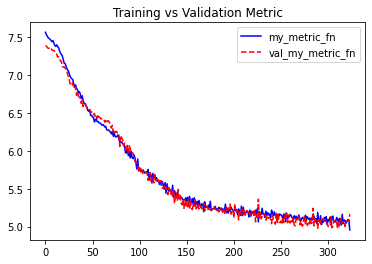

my_metric_fn :  4.956048011779785 val_my_metric_fn :  5.164414405822754


In [17]:
model = Sequential([
        Dense(32, input_shape=(10,), activation = 'relu'),
        Dense(1,)
    ])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',
              metrics=[my_metric_fn])

earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

history = model.fit(train_X_scaled, train_y, epochs = 500, validation_split = 0.25, batch_size=128,
                    shuffle = True, verbose = 0, callbacks = [earlystopper, tqdm_callback])
# plot_loss(history.history)
plot_metric(history.history)

## So MSE of about 5 in the DL model is our baseline, and our focus will be to improve this MSE of integer predictions for both training as well as validation sets, and also reduce variability in the results

In [18]:
# This code block creates a submission file
preds = model.predict(final_X_scaled)
preds = pd.DataFrame(np.round(preds).astype('int'), columns=['rings'])
preds.to_csv('sub_nn_k_3.csv', index=False)

## Now we create feature interactions - 2nd order as well as 3rd order features

In [19]:
display(train_X.head(1))
display(final_X.head(1))

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M
0,124,97,41,243.8,77.5,50.1,77.0,0,0,1


,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M
0,111,87,29,139.5,52.4,31.5,48.0,0,1,0


In [20]:
# Pair interactions
cols = list(train_X.columns)
n = len(cols)
for i in range(0, n-1):
    for j in range(i+1, n):
        train_X['inter_'+str(i)+'_'+str(j)] = train_X[cols[i]] * train_X[cols[j]]
        final_X['inter_'+str(i)+'_'+str(j)] = final_X[cols[i]] * final_X[cols[j]]
display(train_X.head(1))
display(final_X.head(1))

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,inter_0_1,inter_0_2,inter_0_3,inter_0_4,inter_0_5,inter_0_6,inter_0_7,inter_0_8,inter_0_9,inter_1_2,inter_1_3,inter_1_4,inter_1_5,inter_1_6,inter_1_7,inter_1_8,inter_1_9,inter_2_3,inter_2_4,inter_2_5,inter_2_6,inter_2_7,inter_2_8,inter_2_9,inter_3_4,inter_3_5,inter_3_6,inter_3_7,inter_3_8,inter_3_9,inter_4_5,inter_4_6,inter_4_7,inter_4_8,inter_4_9,inter_5_6,inter_5_7,inter_5_8,inter_5_9,inter_6_7,inter_6_8,inter_6_9,inter_7_8,inter_7_9,inter_8_9
0,124,97,41,243.8,77.5,50.1,77.0,0,0,1,12028,5084,30231.2,9610.0,6212.4,9548.0,0,0,124,3977,23648.6,7517.5,4859.7,7469.0,0,0,97,9995.8,3177.5,2054.1,3157.0,0,0,41,18894.5,12214.38,18772.6,0.0,0.0,243.8,3882.75,5967.5,0.0,0.0,77.5,3857.7,0.0,0.0,50.1,0.0,0.0,77.0,0,0,0


,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,inter_0_1,inter_0_2,inter_0_3,inter_0_4,inter_0_5,inter_0_6,inter_0_7,inter_0_8,inter_0_9,inter_1_2,inter_1_3,inter_1_4,inter_1_5,inter_1_6,inter_1_7,inter_1_8,inter_1_9,inter_2_3,inter_2_4,inter_2_5,inter_2_6,inter_2_7,inter_2_8,inter_2_9,inter_3_4,inter_3_5,inter_3_6,inter_3_7,inter_3_8,inter_3_9,inter_4_5,inter_4_6,inter_4_7,inter_4_8,inter_4_9,inter_5_6,inter_5_7,inter_5_8,inter_5_9,inter_6_7,inter_6_8,inter_6_9,inter_7_8,inter_7_9,inter_8_9
0,111,87,29,139.5,52.4,31.5,48.0,0,1,0,9657,3219,15484.5,5816.4,3496.5,5328.0,0,111,0,2523,12136.5,4558.8,2740.5,4176.0,0,87,0,4045.5,1519.6,913.5,1392.0,0,29,0,7309.8,4394.25,6696.0,0.0,139.5,0.0,1650.6,2515.2,0.0,52.4,0.0,1512.0,0.0,31.5,0.0,0.0,48.0,0.0,0,0,0


In [21]:
# 3rd order interactions
cols = list(train_X.columns)[:10]
n = len(cols)
for i in range(0, n-2):     # This will range from 0 to 57
    for j in range(i+1, n-1):
        for k in range(j+1, n):
            train_X['inter_'+str(i)+'_'+str(j)+'_'+str(k)] = train_X[cols[i]] * train_X[cols[j]] * train_X[cols[k]]
            final_X['inter_'+str(i)+'_'+str(j)+'_'+str(k)] = final_X[cols[i]] * final_X[cols[j]] * final_X[cols[k]]
display(train_X.head(1))
display(final_X.head(1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,inter_0_1,inter_0_2,inter_0_3,inter_0_4,inter_0_5,inter_0_6,inter_0_7,inter_0_8,inter_0_9,inter_1_2,inter_1_3,inter_1_4,inter_1_5,inter_1_6,inter_1_7,inter_1_8,inter_1_9,inter_2_3,inter_2_4,inter_2_5,inter_2_6,inter_2_7,inter_2_8,inter_2_9,inter_3_4,inter_3_5,inter_3_6,inter_3_7,inter_3_8,inter_3_9,inter_4_5,inter_4_6,inter_4_7,inter_4_8,inter_4_9,inter_5_6,inter_5_7,inter_5_8,inter_5_9,inter_6_7,inter_6_8,inter_6_9,inter_7_8,inter_7_9,inter_8_9,inter_0_1_2,inter_0_1_3,inter_0_1_4,inter_0_1_5,inter_0_1_6,inter_0_1_7,inter_0_1_8,inter_0_1_9,inter_0_2_3,inter_0_2_4,inter_0_2_5,inter_0_2_6,inter_0_2_7,inter_0_2_8,inter_0_2_9,inter_0_3_4,inter_0_3_5,inter_0_3_6,inter_0_3_7,inter_0_3_8,inter_0_3_9,inter_0_4_5,inter_0_4_6,inter_0_4_7,inter_0_4_8,inter_0_4_9,inter_0_5_6,inter_0_5_7,inter_0_5_8,inter_0_5_9,inter_0_6_7,inter_0_6_8,inter_0_6_9,inter_0_7_8,inter_0_7_9,inter_0_8_9,inter_1_2_3,inter_1_2_4,inter_1_2_5,inter_1_2_6,inter_1_2_7,inter_1_2_8,inter_1_2_9,inter_1_3_4,inter_1_3_5,inter_1_3_6,inter_1_3_7,inter_1_3_8,inter_1_3_9,inter_1_4_5,inter_1_4_6,inter_1_4_7,inter_1_4_8,inter_1_4_9,inter_1_5_6,inter_1_5_7,inter_1_5_8,inter_1_5_9,inter_1_6_7,inter_1_6_8,inter_1_6_9,inter_1_7_8,inter_1_7_9,inter_1_8_9,inter_2_3_4,inter_2_3_5,inter_2_3_6,inter_2_3_7,inter_2_3_8,inter_2_3_9,inter_2_4_5,inter_2_4_6,inter_2_4_7,inter_2_4_8,inter_2_4_9,inter_2_5_6,inter_2_5_7,inter_2_5_8,inter_2_5_9,inter_2_6_7,inter_2_6_8,inter_2_6_9,inter_2_7_8,inter_2_7_9,inter_2_8_9,inter_3_4_5,inter_3_4_6,inter_3_4_7,inter_3_4_8,inter_3_4_9,inter_3_5_6,inter_3_5_7,inter_3_5_8,inter_3_5_9,inter_3_6_7,inter_3_6_8,inter_3_6_9,inter_3_7_8,inter_3_7_9,inter_3_8_9,inter_4_5_6,inter_4_5_7,inter_4_5_8,inter_4_5_9,inter_4_6_7,inter_4_6_8,inter_4_6_9,inter_4_7_8,inter_4_7_9,inter_4_8_9,inter_5_6_7,inter_5_6_8,inter_5_6_9,inter_5_7_8,inter_5_7_9,inter_5_8_9,inter_6_7_8,inter_6_7_9,inter_6_8_9,inter_7_8_9
0,124,97,41,243.8,77.5,50.1,77.0,0,0,1,12028,5084,30231.2,9610.0,6212.4,9548.0,0,0,124,3977,23648.6,7517.5,4859.7,7469.0,0,0,97,9995.8,3177.5,2054.1,3157.0,0,0,41,18894.5,12214.38,18772.6,0.0,0.0,243.8,3882.75,5967.5,0.0,0.0,77.5,3857.7,0.0,0.0,50.1,0.0,0.0,77.0,0,0,0,493148,2932426.4,932170.0,602602.8,926156.0,0,0,12028,1239479.2,394010.0,254708.4,391468.0,0,0,5084,2342918.0,1514583.12,2327802.4,0.0,0.0,30231.2,481461.0,739970.0,0.0,0.0,9610.0,478354.8,0.0,0.0,6212.4,0.0,0.0,9548.0,0,0,0,969592.6,308217.5,199247.7,306229.0,0,0,3977,1832766.5,1184794.86,1820942.2,0.0,0.0,23648.6,376626.75,578847.5,0.0,0.0,7517.5,374196.9,0.0,0.0,4859.7,0.0,0.0,7469.0,0,0,0,774674.5,500789.58,769676.6,0.0,0.0,9995.8,159192.75,244667.5,0.0,0.0,3177.5,158165.7,0.0,0.0,2054.1,0.0,0.0,3157.0,0,0,0,946614.45,1454876.5,0.0,0.0,18894.5,940507.26,0.0,0.0,12214.38,0.0,0.0,18772.6,0.0,0.0,0.0,298971.75,0.0,0.0,3882.75,0.0,0.0,5967.5,0.0,0.0,0.0,0.0,0.0,3857.7,0.0,0.0,0.0,0.0,0.0,0.0,0


,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,inter_0_1,inter_0_2,inter_0_3,inter_0_4,inter_0_5,inter_0_6,inter_0_7,inter_0_8,inter_0_9,inter_1_2,inter_1_3,inter_1_4,inter_1_5,inter_1_6,inter_1_7,inter_1_8,inter_1_9,inter_2_3,inter_2_4,inter_2_5,inter_2_6,inter_2_7,inter_2_8,inter_2_9,inter_3_4,inter_3_5,inter_3_6,inter_3_7,inter_3_8,inter_3_9,inter_4_5,inter_4_6,inter_4_7,inter_4_8,inter_4_9,inter_5_6,inter_5_7,inter_5_8,inter_5_9,inter_6_7,inter_6_8,inter_6_9,inter_7_8,inter_7_9,inter_8_9,inter_0_1_2,inter_0_1_3,inter_0_1_4,inter_0_1_5,inter_0_1_6,inter_0_1_7,inter_0_1_8,inter_0_1_9,inter_0_2_3,inter_0_2_4,inter_0_2_5,inter_0_2_6,inter_0_2_7,inter_0_2_8,inter_0_2_9,inter_0_3_4,inter_0_3_5,inter_0_3_6,inter_0_3_7,inter_0_3_8,inter_0_3_9,inter_0_4_5,inter_0_4_6,inter_0_4_7,inter_0_4_8,inter_0_4_9,inter_0_5_6,inter_0_5_7,inter_0_5_8,inter_0_5_9,inter_0_6_7,inter_0_6_8,inter_0_6_9,inter_0_7_8,inter_0_7_9,inter_0_8_9,inter_1_2_3,inter_1_2_4,inter_1_2_5,inter_1_2_6,inter_1_2_7,inter_1_2_8,inter_1_2_9,inter_1_3_4,inter_1_3_5,inter_1_3_6,inter_1_3_7,inter_1_3_8,inter_1_3_9,inter_1_4_5,inter_1_4_6,inter_1_4_7,inter_1_4_8,inter_1_4_9,inter_1_5_6,inter_1_5_7,inter_1_5_8,inter_1_5_9,inter_1_6_7,inter_1_6_8,inter_1_6_9,inter_1_7_8,inter_1_7_9,inter_1_8_9,inter_2_3_4,inter_2_3_5,inter_2_3_6,inter_2_3_7,inter_2_3_8,inter_2_3_9,inter_2_4_5,inter_2_4_6,inter_2_4_7,inter_2_4_8,inter_2_4_9,inter_2_5_6,inter_2_5_7,inter_2_5_8,inter_2_5_9,inter_2_6_7,inter_2_6_8,inter_2_6_9,inter_2_7_8,inter_2_7_9,inter_2_8_9,inter_3_4_5,inter_3_4_6,inter_3_4_7,inter_3_4_8,inter_3_4_9,inter_3_5_6,inter_3_5_7,inter_3_5_8,inter_3_5_9,inter_3_6_7,inter_3_6_8,inter_3_6_9,inter_3_7_8,inter_3_7_9,inter_3_8_9,inter_4_5_6,inter_4_5_7,inter_4_5_8,inter_4_5_9,inter_4_6_7,inter_4_6_8,inter_4_6_9,inter_4_7_8,inter_4_7_9,inter_4_8_9,inter_5_6_7,inter_5_6_8,inter_5_6_9,inter_5_7_8,inter_5_7_9,inter_5_8_9,inter_6_7_8,inter_6_7_9,inter_6_8_9,inter_7_8_9
0,111,87,29,139.5,52.4,31.5,48.0,0,1,0,9657,3219,15484.5,5816.4,3496.5,5328.0,0,111,0,2523,12136.5,4558.8,2740.5,4176.0,0,87,0,4045.5,1519.6,913.5,1392.0,0,29,0,7309.8,4394.25,6696.0,0.0,139.5,0.0,1650.6,2515.2,0.0,52.4,0.0,1512.0,0.0,31.5,0.0,0.0,48.0,0.0,0,0,0,280053,1347151.5,506026.8,304195.5,463536.0,0,9657,0,449050.5,168675.6,101398.5,154512.0,0,3219,0,811387.8,487761.75,743256.0,0.0,15484.5,0.0,183216.6,279187.2,0.0,5816.4,0.0,167832.0,0.0,3496.5,0.0,0.0,5328.0,0.0,0,0,0,351958.5,132205.2,79474.5,121104.0,0,2523,0,635952.6,382299.75,582552.0,0.0,12136.5,0.0,143602.2,218822.4,0.0,4558.8,0.0,131544.0,0.0,2740.5,0.0,0.0,4176.0,0.0,0,0,0,211984.2,127433.25,194184.0,0.0,4045.5,0.0,47867.4,72940.8,0.0,1519.6,0.0,43848.0,0.0,913.5,0.0,0.0,1392.0,0.0,0,0,0,230258.7,350870.4,0.0,7309.8,0.0,210924.0,0.0,4394.25,0.0,0.0,6696.0,0.0,0.0,0.0,0.0,79228.8,0.0,1650.6,0.0,0.0,2515.2,0.0,0.0,0.0,0.0,0.0,1512.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Normalizing the features

In [22]:
scaler = MinMaxScaler()
train_X_scaled = scaler.fit_transform(train_X)
final_X_scaled = scaler.transform(final_X)

In [23]:
train_X_scaled.shape

(3550, 175)

## Now we have a total of 175 features in our datasets. My computer is old and can achieve only so much as the previous ML notebook I shared. From here on, only kaggle GPU can help out.

## ANN - 2 Our new DL model

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 00051: early stopping


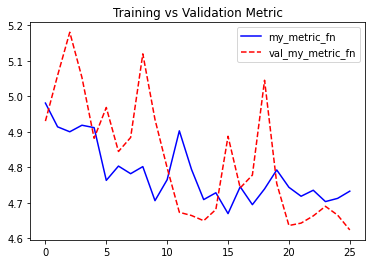

my_metric_fn :  4.732907772064209 val_my_metric_fn :  4.623873710632324


In [24]:
model = Sequential([
        Dense(256, input_shape=(175,), activation = 'relu'), 
        Dense(32, activation = 'relu'),
        Dense(256, activation = 'tanh'),
        Dense(1,)
    ])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',   
              metrics=[my_metric_fn])

earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

history = model.fit(train_X_scaled, train_y, epochs = 100, validation_split = 0.25, batch_size=256,
                    shuffle = True, verbose = 0, callbacks = [earlystopper, tqdm_callback])  
# plot_loss(history.history)
plot_metric(history.history)

In [26]:
# Code block for making submissions
preds = model.predict(final_X_scaled)
preds = pd.DataFrame(np.round(preds).astype('int'), columns=['rings'])
preds.to_csv('sub24_nn_k_5.csv', index=False)

## This model architecture above gave a good result on DPhi LB: 2.13

## Next ANN model

Training:   0%|           0/1000 ETA: ?s,  ?epochs/s

Epoch 00277: early stopping


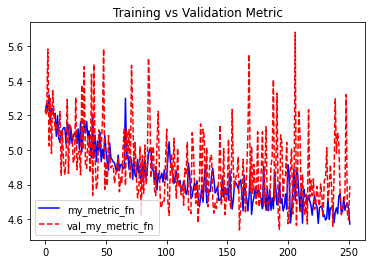

my_metric_fn :  4.5725016593933105 val_my_metric_fn :  4.792792797088623


In [27]:
model = Sequential([
        Dense(512, input_shape=(175,), activation = 'relu', kernel_initializer='random_normal',
              kernel_regularizer=regularizers.l1(0.001)),
        Dense(1,)
    ])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',   
              metrics=[my_metric_fn])

earlystopper = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

history = model.fit(train_X_scaled, train_y, epochs = 1000, validation_split = 0.25, batch_size=128,
                    shuffle = True, verbose = 0, callbacks = [earlystopper, tqdm_callback])  
# plot_loss(history.history)
plot_metric(history.history)

## This architecture above gave an even better score on the DPhi LB: 2.05; On full training data with shuffle off it gave 2.077 and on full training data with shuffle on it gave 2.08;

## The model architecture below was used to continue on the path of reducing the integer MSE scores for both train and val sets. In all, about a hundred iterations were carried out. Beyond a point, gave up further finetuning and moved on with life!

Training:   0%|           0/1000 ETA: ?s,  ?epochs/s

Epoch 00447: early stopping


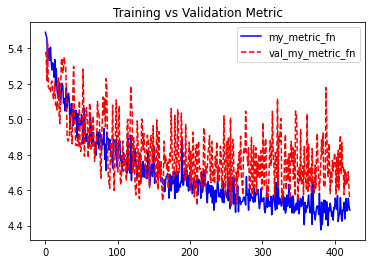

my_metric_fn :  4.486852169036865 val_my_metric_fn :  4.549549579620361


In [28]:
model = Sequential([
        Dense(512, input_shape=(175,), activation = 'relu', kernel_initializer='random_normal',
              kernel_regularizer=regularizers.l1(0.001)),   # , kernel_regularizer=regularizers.l2(0.01)
        Dropout(0.05),
        Dense(1024, activation = 'relu', kernel_initializer='he_normal', 
             kernel_regularizer=regularizers.l2(0.001)),   # orthogonal, he_uniform, random_normal, he_normal
        Dropout(0.05),
#         Dense(1024, activation = 'relu'),
        Dense(1,)
    ])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',   # Adam(learning_rate=0.001)
              metrics=[my_metric_fn])

earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

history = model.fit(train_X_scaled, train_y, epochs = 1000, validation_split = 0.25, batch_size=128,
                    shuffle = True, verbose = 0, callbacks = [earlystopper, tqdm_callback]) # earlystopper, 
# plot_loss(history.history)
plot_metric(history.history)

## End of the notebook

In [29]:
preds = model.predict(final_X_scaled)
preds = pd.DataFrame(np.round(preds).astype('int'), columns=['rings'])
preds.to_csv('one_last_time.csv', index=False)